#0. Imports

In [315]:
import cv2
import numpy as np
import re
import math 
from PIL import Image

In [316]:
#NOTE: install following libraries if they are missing

!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


At the time of making notebook, version of libs were:

cv2 : 4.7.0

np : 1.22.4

re : 2.2.1

pytesseract : 0.3.10

In [317]:
import pytesseract
from pytesseract import Output

#1. Loading data

###1.1 Dataset explanation

Dateset I'm working with contains images with indentity card that contain name, birthdate, job position, social security number, company name and image of persone.
I got this dataset for university project, so i will not upload it.
I think it is make using mswordidcards com, and is not available online.
Feel free to make your own card or find some dataset online.

In [318]:
image_path = "image_example.png"
image = cv2.imread(image_path)

In [319]:
#there is some problem with cv2.im_show so i will be using cv2_imshow
#maybe you won't have this problem
from google.colab.patches import cv2_imshow

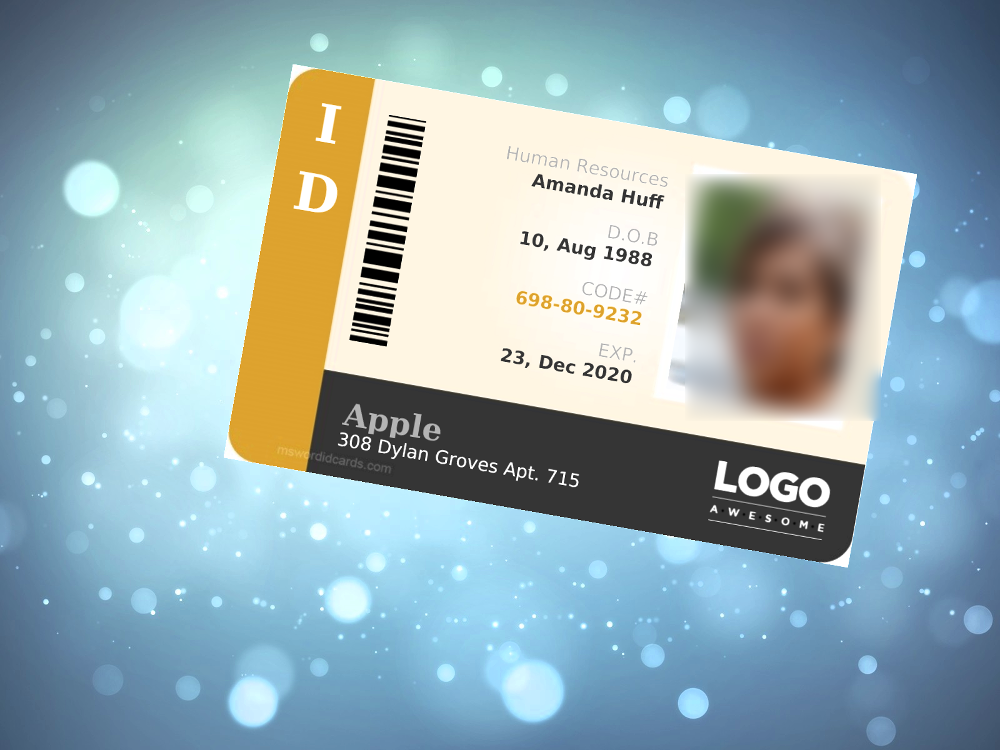

In [320]:
cv2_imshow(image)

#2. Helper functions

Here are some imteresting functions you can apply for image processing before sending image to tesseract

In [321]:
#function that takes an input image as an argument and returns a grayscale version of that image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


#function that takes an input image as an argument and applies a thresholding operation to the image
# In this case, the function uses a combination of binary thresholding (cv2.THRESH_BINARY)
# and Otsu's thresholding method (cv2.THRESH_OTSU) to determine the threshold value.
#Feel free to try some other thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


#function that takes an input image as an argument and applies a dilation operation to the image.
def dilate(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

#function that takes an input image as an argument and applies a erosion operation to the image.
def erode(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#The morphological opening operation is a combination of two operations: erosion followed by dilation.
def opening(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#The morphological closing operation is a combination of two operations: dilation followed by erosion.
def closing(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)


#function takes an input image as an argument and applies the Canny edge detection algorithm to the image
#The Canny edge detection algorithm is a widely-used method for detecting edges in images.
#It works by first smoothing the image to remove noise, then calculating the gradient of the image intensity,
# and finally identifying and linking edges based on their gradient magnitude and orientation.
def canny(image):
    return cv2.Canny(image, 256, 256)

#3. Reading text from loaded image

In [322]:
image_path = "image_example.png"
image = cv2.imread(image_path)

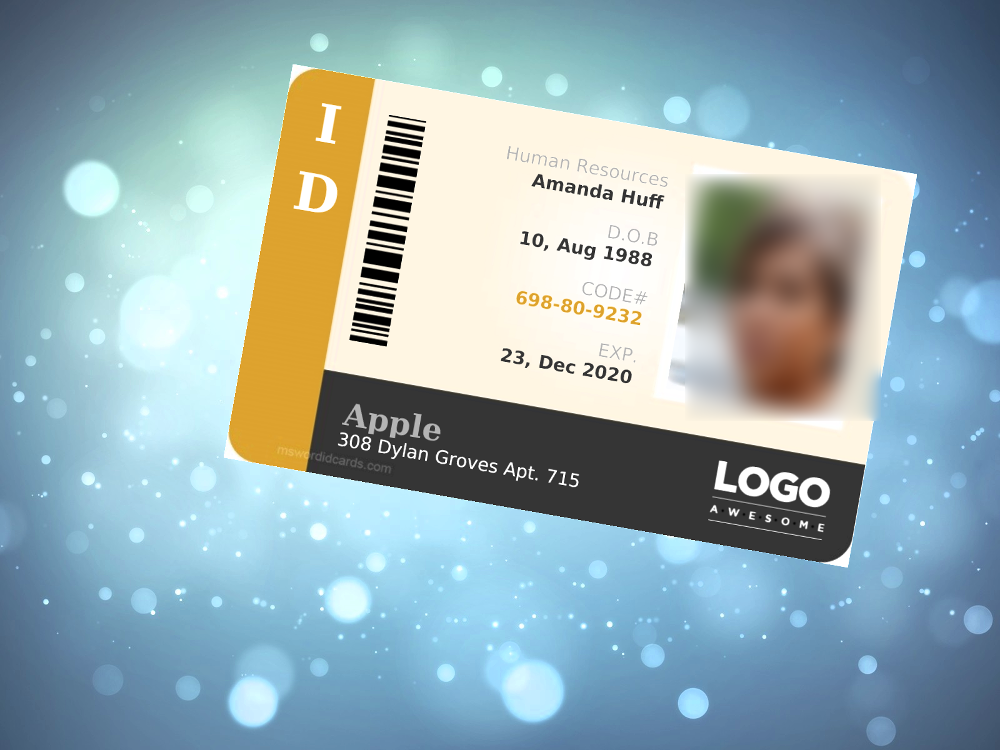

In [323]:
cv2_imshow(image)

In [324]:
#reading text with pytesseract
# --oem stands for "OCR Engine Mode" and controls the OCR engine that Tesseract uses for character recognition.
# --psm stands for "Page Segmentation Mode" and controls how Tesseract segments the image into individual characters and words.
#feel free to try some other config
config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(image, config=config)

In [325]:
print(text)

IE '
— Amanda Huff
| )) =
= 10, Aug 1989
=
=
= £98-80-9235
=
= 23, Dec 2020
EVES coer
Ei) PEN Groves Apt. 715 mee



In [326]:
#regex for finding social security number in my image example
ssn = re.findall("\d+[-]\d+[-]\d+", text)
print(ssn)

['98-80-9235']


In [327]:
#regex for finding dates in my image example
date = re.findall("\d{2}[,][ ][a-zA-Z]{3}[ ]\d{4}", text)
print(date)

['10, Aug 1989', '23, Dec 2020']


#4. Rotating and cropping image for better text reading


The following code is example of posible solution for image rotation.
The code reads an image, applies edge detection, finds the first line in the detected edges, calculates its angle, and rotates the image accordingly.
After that comes code for cropping image.

In [328]:
image_path = "image_example.png"
image = cv2.imread(image_path)
gray = get_grayscale(image)
try:
  (h, w) = image.shape[:2]
  (cX, cY) = (w // 2, h // 2)
  edges = cv2.Canny(gray, 30, 180)
  
  lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 40, minLineLength=30, maxLineGap=50)
  (x1, y1, x2, y2) = lines[0][0]
  slope = (y1 - y2)/(x1-x2)
  
  angle = math.degrees(math.atan(slope))
  
  M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
  rotated = cv2.warpAffine(image, M, (w, h))
except:
  rotated = image

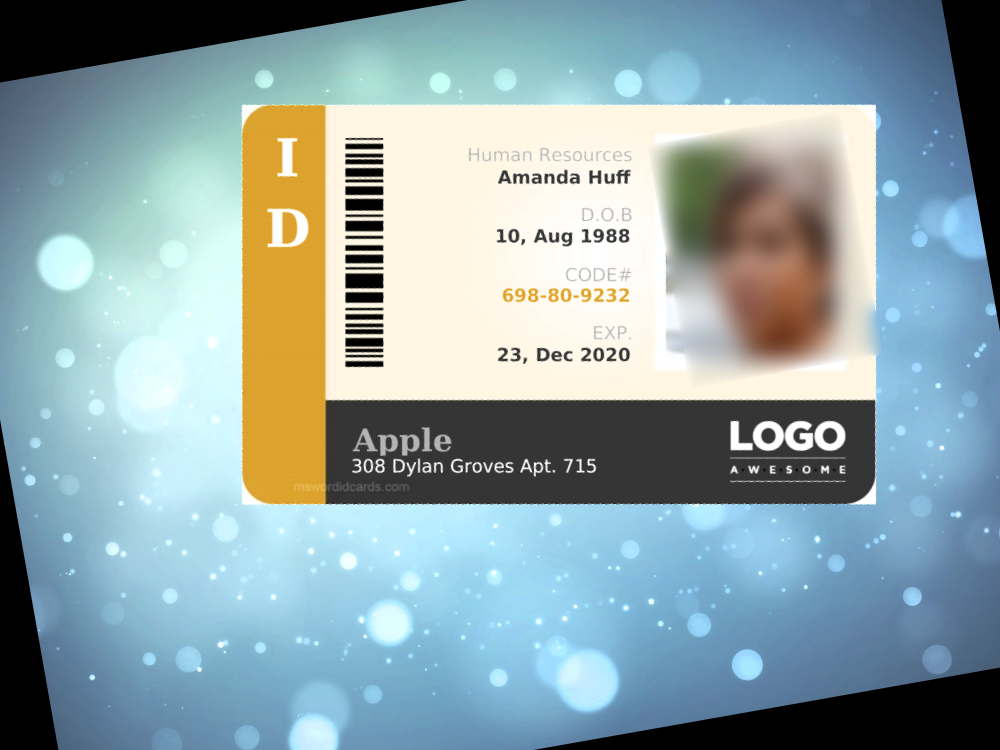

In [329]:
cv2_imshow(rotated)

In [330]:
rotated_without_cut = rotated

img_gray = cv2.cvtColor(rotated, cv2.COLOR_RGB2GRAY)
(h, w) = image.shape[:2]
(cX, cY) = (w // 2, h // 2)
edges = cv2.Canny(img_gray, 50, 150)

contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

contours = sorted(contours, key=cv2.contourArea, reverse=True)

try:
  x, y, w, h = cv2.boundingRect(contours[0])
  rect = rotated[y:y + h, x:x + w]
  rotated_image_with_crop = rect
except:
  rotated_image_with_crop = rotated

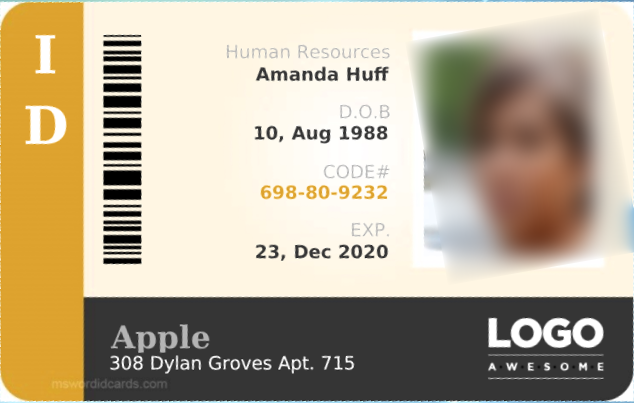

In [331]:
cv2_imshow(rotated_image_with_crop)

###4.1 Reading text from rotated image

In [332]:
config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(rotated_image_with_crop, config=config)

In [333]:
print(text)

a Amanda Huff

—

_—

— 10, Aug 1988

ae

=

favesee!

=
—=

= 23, Dec 2020

Apple LOGO
308 Dylan Groves Apt. 715 ae



In [334]:
#regex for finding social security number in my image example
ssn = re.findall("\d+[-]\d+[-]\d+", text)
print(ssn)

[]


In [335]:
#regex for finding dates in my image example
date = re.findall("\d{2}[,][ ][a-zA-Z]{3}[ ]\d{4}", text)
print(date)

['10, Aug 1988', '23, Dec 2020']


###4.2 Gray rotated image

In [336]:
gray = get_grayscale(rotated_image_with_crop)

In [337]:
config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(gray, config=config)

In [338]:
print(text)

== Amanda Huff

—

LJ

— 10, Aug 1988

—

=

—

—=

> 23, Dec 2020

NaN LOGO
308 Dylan Groves Apt. 715 Lt



In [339]:
#regex for finding social security number in my image example
ssn = re.findall("\d+[-]\d+[-]\d+", text)
print(ssn)

[]


In [340]:
#regex for finding dates in my image example
date = re.findall("\d{2}[,][ ][a-zA-Z]{3}[ ]\d{4}", text)
print(date)

['10, Aug 1988', '23, Dec 2020']
